In [2]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [17]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

==>>> total training batch number: 300
==>>> total testing batch number: 50


In [3]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass
    
class BN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(BN, self).__init__()
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
    def forward(self, x):
        
        beta = x.mean(0, keepdim=True)
        alpha = ((x-beta)**2).mean(0, keepdim=True).sqrt()

        # Normalize
        nx = (x-beta)/alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return o

    def update(self, u, v, eta=None):
        pass

class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # gain/bias are the learned output distribution params
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return  o
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Eu = u.mean(0, keepdim=True)
            Euu = (u**2).mean(0, keepdim=True)
            Ev = v.mean(0, keepdim=True)
            Evv = (v**2).mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta * (2*(Euv))
        self.beta = (1-eta)*self.beta + eta * (2*Ev)
        
        self.eta = eta * 0.99


class DNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(DNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        
        return o

In [4]:
def train_deep_model(network, optimization, seed, epochs):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0

        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
    print("Finished training!\n")
    return(np.transpose(loss_tracker))

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50

test_runs = 10

int_lr = 0.3
syn_lr = 0.001

seed = random.randint(0, 1000000)

#Train IP Model
torch.manual_seed(seed)
IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
IPnet = IPnet.to(device)

optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
print("Training IP Net")
ip_losses = train_deep_model(IPnet, optimizer1, seed)


#Train Standard Model
torch.manual_seed(seed)
net = DNet(LAYERSIZE, NN, eta=int_lr)
net = net.to(device)

optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
print("Training Standard Net")
standard_losses = train_deep_model(net, optimizer2, seed)

for i in range(test_runs-1):
    seed = random.randint(0, 1000000)
    
    #Train IP Model
    torch.manual_seed(seed)
    IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net")
    ip_losses += train_deep_model(IPnet, optimizer1, seed)


    #Train Standard Model
    torch.manual_seed(seed)
    net = DNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net")
    standard_losses += train_deep_model(net, optimizer2, seed)
    
ip_losses = ip_losses/test_runs
standard_losses = standard_losses/test_runs

Training IP Net
[1,   100] loss: 1.094
[1,   200] loss: 0.352
[1,   300] loss: 0.261
[2,   100] loss: 0.225
[2,   200] loss: 0.209
[2,   300] loss: 0.196
[3,   100] loss: 0.159
[3,   200] loss: 0.163
[3,   300] loss: 0.161
[4,   100] loss: 0.136
[4,   200] loss: 0.138
[4,   300] loss: 0.142
[5,   100] loss: 0.121
[5,   200] loss: 0.119
[5,   300] loss: 0.130
[6,   100] loss: 0.102
[6,   200] loss: 0.106
[6,   300] loss: 0.114
[7,   100] loss: 0.088
[7,   200] loss: 0.098
[7,   300] loss: 0.112
[8,   100] loss: 0.086
[8,   200] loss: 0.092
[8,   300] loss: 0.093
[9,   100] loss: 0.081
[9,   200] loss: 0.082
[9,   300] loss: 0.097
[10,   100] loss: 0.080
[10,   200] loss: 0.081
[10,   300] loss: 0.087
[11,   100] loss: 0.080
[11,   200] loss: 0.077
[11,   300] loss: 0.074
[12,   100] loss: 0.072
[12,   200] loss: 0.078
[12,   300] loss: 0.076
[13,   100] loss: 0.062
[13,   200] loss: 0.059
[13,   300] loss: 0.078
[14,   100] loss: 0.060
[14,   200] loss: 0.061
[14,   300] loss: 0.080
[15

[14,   200] loss: 0.065
[14,   300] loss: 0.068
[15,   100] loss: 0.050
[15,   200] loss: 0.063
[15,   300] loss: 0.061
[16,   100] loss: 0.051
[16,   200] loss: 0.055
[16,   300] loss: 0.060
[17,   100] loss: 0.045
[17,   200] loss: 0.057
[17,   300] loss: 0.064
[18,   100] loss: 0.045
[18,   200] loss: 0.055
[18,   300] loss: 0.059
[19,   100] loss: 0.044
[19,   200] loss: 0.041
[19,   300] loss: 0.047
[20,   100] loss: 0.039
[20,   200] loss: 0.043
[20,   300] loss: 0.044
Finished training!

Training IP Net
[1,   100] loss: 1.017
[1,   200] loss: 0.347
[1,   300] loss: 0.270
[2,   100] loss: 0.207
[2,   200] loss: 0.199
[2,   300] loss: 0.195
[3,   100] loss: 0.159
[3,   200] loss: 0.154
[3,   300] loss: 0.151
[4,   100] loss: 0.121
[4,   200] loss: 0.137
[4,   300] loss: 0.127
[5,   100] loss: 0.112
[5,   200] loss: 0.108
[5,   300] loss: 0.120
[6,   100] loss: 0.099
[6,   200] loss: 0.098
[6,   300] loss: 0.107
[7,   100] loss: 0.085
[7,   200] loss: 0.090
[7,   300] loss: 0.093
[

[7,   100] loss: 0.130
[7,   200] loss: 0.126
[7,   300] loss: 0.117
[8,   100] loss: 0.111
[8,   200] loss: 0.118
[8,   300] loss: 0.112
[9,   100] loss: 0.098
[9,   200] loss: 0.099
[9,   300] loss: 0.097
[10,   100] loss: 0.089
[10,   200] loss: 0.091
[10,   300] loss: 0.093
[11,   100] loss: 0.083
[11,   200] loss: 0.077
[11,   300] loss: 0.083
[12,   100] loss: 0.076
[12,   200] loss: 0.077
[12,   300] loss: 0.069
[13,   100] loss: 0.067
[13,   200] loss: 0.065
[13,   300] loss: 0.077
[14,   100] loss: 0.067
[14,   200] loss: 0.061
[14,   300] loss: 0.062
[15,   100] loss: 0.054
[15,   200] loss: 0.057
[15,   300] loss: 0.061
[16,   100] loss: 0.052
[16,   200] loss: 0.060
[16,   300] loss: 0.061
[17,   100] loss: 0.054
[17,   200] loss: 0.050
[17,   300] loss: 0.059
[18,   100] loss: 0.049
[18,   200] loss: 0.051
[18,   300] loss: 0.050
[19,   100] loss: 0.042
[19,   200] loss: 0.048
[19,   300] loss: 0.049
[20,   100] loss: 0.043
[20,   200] loss: 0.046
[20,   300] loss: 0.048
F

[20,   200] loss: 0.049
[20,   300] loss: 0.050
Finished training!

Training Standard Net
[1,   100] loss: 1.857
[1,   200] loss: 1.089
[1,   300] loss: 0.796
[2,   100] loss: 0.655
[2,   200] loss: 0.561
[2,   300] loss: 0.465
[3,   100] loss: 0.358
[3,   200] loss: 0.318
[3,   300] loss: 0.291
[4,   100] loss: 0.237
[4,   200] loss: 0.230
[4,   300] loss: 0.203
[5,   100] loss: 0.187
[5,   200] loss: 0.175
[5,   300] loss: 0.170
[6,   100] loss: 0.142
[6,   200] loss: 0.152
[6,   300] loss: 0.145
[7,   100] loss: 0.122
[7,   200] loss: 0.118
[7,   300] loss: 0.136
[8,   100] loss: 0.101
[8,   200] loss: 0.116
[8,   300] loss: 0.108
[9,   100] loss: 0.098
[9,   200] loss: 0.094
[9,   300] loss: 0.095
[10,   100] loss: 0.080
[10,   200] loss: 0.100
[10,   300] loss: 0.094
[11,   100] loss: 0.078
[11,   200] loss: 0.087
[11,   300] loss: 0.092
[12,   100] loss: 0.076
[12,   200] loss: 0.072
[12,   300] loss: 0.078
[13,   100] loss: 0.063
[13,   200] loss: 0.074
[13,   300] loss: 0.071
[

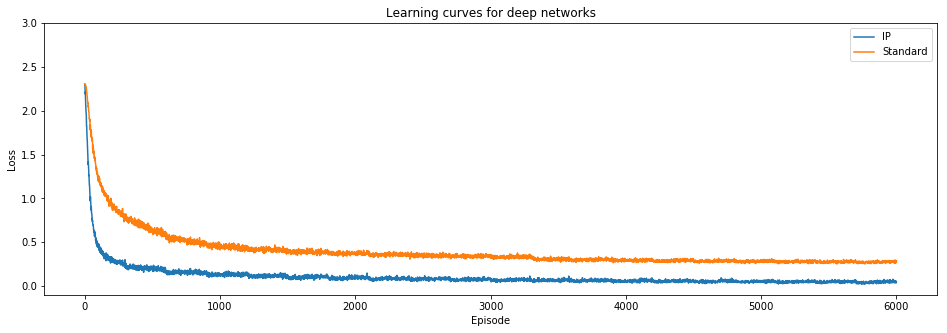

In [9]:
plt.figure(figsize=(16, 5))
plt.ylim([-0.1, 3])
plt.title("Learning curves for deep networks")
plt.plot(ip_losses[0], ip_losses[1], label="IP")
# plt.plot(bn_losses[0], bn_losses[1], label="BN")
plt.plot(standard_losses[0], standard_losses[1], label="Standard")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y = net(images)
        _, predicted = torch.max(y.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the standard network on the 10000 test images: %.4f %%' % (
    100 * correct / total))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y = IPnet(images)
        _, predicted = torch.max(y.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the IP network on the 10000 test images: %.4f %%' % (
    100 * correct / total))

Accuracy of the standard network on the 10000 test images: 96.6800 %
Accuracy of the IP network on the 10000 test images: 96.5700 %


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50

test_runs = 10

int_lr = 0.3
syn_lr = 0.003

seed = random.randint(0, 1000000)

#Train IP Model
torch.manual_seed(seed)
IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
IPnet = IPnet.to(device)

optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
print("Training IP Net")
ip_losses = train_deep_model(IPnet, optimizer1, seed)


#Train Standard Model
torch.manual_seed(seed)
net = DNet(LAYERSIZE, NN, eta=int_lr)
net = net.to(device)

optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
print("Training Standard Net")
standard_losses = train_deep_model(net, optimizer2, seed)

for i in range(test_runs-1):
    seed = random.randint(0, 1000000)
    
    #Train IP Model
    torch.manual_seed(seed)
    IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net")
    ip_losses += train_deep_model(IPnet, optimizer1, seed)


    #Train Standard Model
    torch.manual_seed(seed)
    net = DNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net")
    standard_losses += train_deep_model(net, optimizer2, seed)
    
ip_losses = ip_losses/test_runs
standard_losses = standard_losses/test_runs

Training IP Net
[1,   100] loss: 0.895
[1,   200] loss: 0.318
[1,   300] loss: 0.270
[2,   100] loss: 0.234
[2,   200] loss: 0.232
[2,   300] loss: 0.215
[3,   100] loss: 0.178
[3,   200] loss: 0.183
[3,   300] loss: 0.160
[4,   100] loss: 0.151
[4,   200] loss: 0.157
[4,   300] loss: 0.160
[5,   100] loss: 0.141
[5,   200] loss: 0.148
[5,   300] loss: 0.150
[6,   100] loss: 0.136
[6,   200] loss: 0.127
[6,   300] loss: 0.128
[7,   100] loss: 0.114
[7,   200] loss: 0.124
[7,   300] loss: 0.129
[8,   100] loss: 0.117
[8,   200] loss: 0.115
[8,   300] loss: 0.114
[9,   100] loss: 0.100
[9,   200] loss: 0.114
[9,   300] loss: 0.110
[10,   100] loss: 0.103
[10,   200] loss: 0.100
[10,   300] loss: 0.094
[11,   100] loss: 0.084
[11,   200] loss: 0.092
[11,   300] loss: 0.096
[12,   100] loss: 0.070
[12,   200] loss: 0.091
[12,   300] loss: 0.094
[13,   100] loss: 0.085
[13,   200] loss: 0.084
[13,   300] loss: 0.087
[14,   100] loss: 0.080
[14,   200] loss: 0.091
[14,   300] loss: 0.085
[15

[14,   200] loss: 0.066
[14,   300] loss: 0.069
[15,   100] loss: 0.062
[15,   200] loss: 0.070
[15,   300] loss: 0.075
[16,   100] loss: 0.063
[16,   200] loss: 0.070
[16,   300] loss: 0.060
[17,   100] loss: 0.057
[17,   200] loss: 0.058
[17,   300] loss: 0.065
[18,   100] loss: 0.060
[18,   200] loss: 0.061
[18,   300] loss: 0.064
[19,   100] loss: 0.048
[19,   200] loss: 0.060
[19,   300] loss: 0.061
[20,   100] loss: 0.053
[20,   200] loss: 0.061
[20,   300] loss: 0.066
Finished training!

Training IP Net
[1,   100] loss: 0.790
[1,   200] loss: 0.280
[1,   300] loss: 0.257
[2,   100] loss: 0.197
[2,   200] loss: 0.206
[2,   300] loss: 0.195
[3,   100] loss: 0.174
[3,   200] loss: 0.172
[3,   300] loss: 0.175
[4,   100] loss: 0.144
[4,   200] loss: 0.160
[4,   300] loss: 0.150
[5,   100] loss: 0.127
[5,   200] loss: 0.136
[5,   300] loss: 0.135
[6,   100] loss: 0.128
[6,   200] loss: 0.121
[6,   300] loss: 0.132
[7,   100] loss: 0.116
[7,   200] loss: 0.119
[7,   300] loss: 0.104
[

[7,   100] loss: 0.103
[7,   200] loss: 0.102
[7,   300] loss: 0.115
[8,   100] loss: 0.097
[8,   200] loss: 0.090
[8,   300] loss: 0.100
[9,   100] loss: 0.085
[9,   200] loss: 0.084
[9,   300] loss: 0.096
[10,   100] loss: 0.081
[10,   200] loss: 0.082
[10,   300] loss: 0.092
[11,   100] loss: 0.080
[11,   200] loss: 0.085
[11,   300] loss: 0.087
[12,   100] loss: 0.069
[12,   200] loss: 0.078
[12,   300] loss: 0.084
[13,   100] loss: 0.072
[13,   200] loss: 0.068
[13,   300] loss: 0.074
[14,   100] loss: 0.070
[14,   200] loss: 0.070
[14,   300] loss: 0.071
[15,   100] loss: 0.067
[15,   200] loss: 0.070
[15,   300] loss: 0.061
[16,   100] loss: 0.055
[16,   200] loss: 0.065
[16,   300] loss: 0.065
[17,   100] loss: 0.055
[17,   200] loss: 0.057
[17,   300] loss: 0.062
[18,   100] loss: 0.062
[18,   200] loss: 0.058
[18,   300] loss: 0.054
[19,   100] loss: 0.060
[19,   200] loss: 0.056
[19,   300] loss: 0.061
[20,   100] loss: 0.049
[20,   200] loss: 0.059
[20,   300] loss: 0.056
F

[20,   200] loss: 0.049
[20,   300] loss: 0.064
Finished training!

Training Standard Net
[1,   100] loss: 1.403
[1,   200] loss: 0.800
[1,   300] loss: 0.584
[2,   100] loss: 0.459
[2,   200] loss: 0.370
[2,   300] loss: 0.357
[3,   100] loss: 0.279
[3,   200] loss: 0.243
[3,   300] loss: 0.218
[4,   100] loss: 0.185
[4,   200] loss: 0.190
[4,   300] loss: 0.176
[5,   100] loss: 0.155
[5,   200] loss: 0.163
[5,   300] loss: 0.161
[6,   100] loss: 0.140
[6,   200] loss: 0.135
[6,   300] loss: 0.142
[7,   100] loss: 0.130
[7,   200] loss: 0.120
[7,   300] loss: 0.134
[8,   100] loss: 0.114
[8,   200] loss: 0.117
[8,   300] loss: 0.116
[9,   100] loss: 0.100
[9,   200] loss: 0.101
[9,   300] loss: 0.107
[10,   100] loss: 0.092
[10,   200] loss: 0.106
[10,   300] loss: 0.100
[11,   100] loss: 0.091
[11,   200] loss: 0.088
[11,   300] loss: 0.095
[12,   100] loss: 0.078
[12,   200] loss: 0.078
[12,   300] loss: 0.095
[13,   100] loss: 0.078
[13,   200] loss: 0.088
[13,   300] loss: 0.086
[

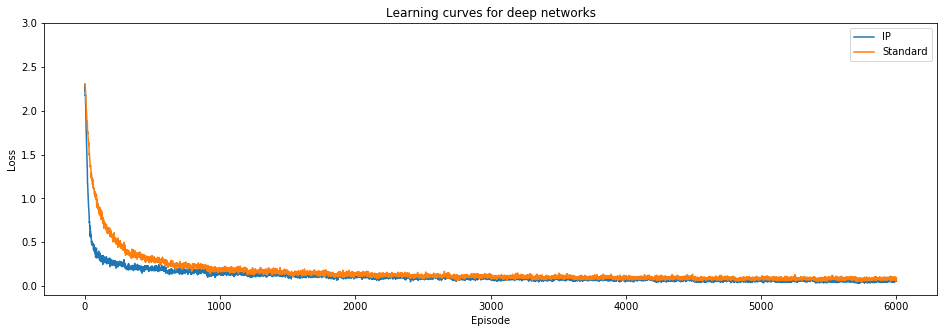

In [21]:
plt.figure(figsize=(16, 5))
plt.ylim([-0.1, 3])
plt.title("Learning curves for deep networks")
plt.plot(ip_losses[0], ip_losses[1], label="IP")
# plt.plot(bn_losses[0], bn_losses[1], label="BN")
plt.plot(standard_losses[0], standard_losses[1], label="Standard")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50

test_runs = 10

int_lr = 0.3
syn_lr = 0.01

seed = random.randint(0, 1000000)

#Train IP Model
torch.manual_seed(seed)
IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
IPnet = IPnet.to(device)

optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
print("Training IP Net")
ip_losses = train_deep_model(IPnet, optimizer1, seed)


#Train Standard Model
torch.manual_seed(seed)
net = DNet(LAYERSIZE, NN, eta=int_lr)
net = net.to(device)

optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
print("Training Standard Net")
standard_losses = train_deep_model(net, optimizer2, seed)

for i in range(test_runs-1):
    seed = random.randint(0, 1000000)
    
    #Train IP Model
    torch.manual_seed(seed)
    IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net")
    ip_losses += train_deep_model(IPnet, optimizer1, seed)


    #Train Standard Model
    torch.manual_seed(seed)
    net = DNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net")
    standard_losses += train_deep_model(net, optimizer2, seed)
    
ip_losses = ip_losses/test_runs
standard_losses = standard_losses/test_runs

Training IP Net
[1,   100] loss: 0.996
[1,   200] loss: 0.407
[1,   300] loss: 0.333
[2,   100] loss: 0.270
[2,   200] loss: 0.272
[2,   300] loss: 0.248
[3,   100] loss: 0.230
[3,   200] loss: 0.212
[3,   300] loss: 0.196
[4,   100] loss: 0.189
[4,   200] loss: 0.175
[4,   300] loss: 0.184
[5,   100] loss: 0.157
[5,   200] loss: 0.157
[5,   300] loss: 0.143
[6,   100] loss: 0.132
[6,   200] loss: 0.148
[6,   300] loss: 0.142
[7,   100] loss: 0.129
[7,   200] loss: 0.135
[7,   300] loss: 0.131
[8,   100] loss: 0.128
[8,   200] loss: 0.128
[8,   300] loss: 0.119
[9,   100] loss: 0.108
[9,   200] loss: 0.104
[9,   300] loss: 0.116
[10,   100] loss: 0.090
[10,   200] loss: 0.099
[10,   300] loss: 0.111
[11,   100] loss: 0.086
[11,   200] loss: 0.104
[11,   300] loss: 0.108
[12,   100] loss: 0.082
[12,   200] loss: 0.088
[12,   300] loss: 0.095
[13,   100] loss: 0.089
[13,   200] loss: 0.080
[13,   300] loss: 0.087
[14,   100] loss: 0.078
[14,   200] loss: 0.080
[14,   300] loss: 0.083
[15

[14,   200] loss: 0.356
[14,   300] loss: 0.354
[15,   100] loss: 0.362
[15,   200] loss: 0.382
[15,   300] loss: 0.387
[16,   100] loss: 0.415
[16,   200] loss: 0.463
[16,   300] loss: 0.444
[17,   100] loss: 0.409
[17,   200] loss: 0.394
[17,   300] loss: 0.413
[18,   100] loss: 0.446
[18,   200] loss: 0.386
[18,   300] loss: 0.398
[19,   100] loss: 0.442
[19,   200] loss: 0.437
[19,   300] loss: 0.431
[20,   100] loss: 0.416
[20,   200] loss: 0.414
[20,   300] loss: 0.439
Finished training!

Training IP Net
[1,   100] loss: 0.752
[1,   200] loss: 0.348
[1,   300] loss: 0.287
[2,   100] loss: 0.237
[2,   200] loss: 0.217
[2,   300] loss: 0.215
[3,   100] loss: 0.188
[3,   200] loss: 0.179
[3,   300] loss: 0.178
[4,   100] loss: 0.190
[4,   200] loss: 0.172
[4,   300] loss: 0.188
[5,   100] loss: 0.161
[5,   200] loss: 0.148
[5,   300] loss: 0.172
[6,   100] loss: 0.154
[6,   200] loss: 0.137
[6,   300] loss: 0.134
[7,   100] loss: 0.129
[7,   200] loss: 0.126
[7,   300] loss: 0.125
[

[7,   100] loss: 0.381
[7,   200] loss: 0.349
[7,   300] loss: 0.323
[8,   100] loss: 0.360
[8,   200] loss: 0.341
[8,   300] loss: 0.333
[9,   100] loss: 0.344
[9,   200] loss: 0.349
[9,   300] loss: 0.351
[10,   100] loss: 0.379
[10,   200] loss: 0.369
[10,   300] loss: 0.345
[11,   100] loss: 0.371
[11,   200] loss: 0.386
[11,   300] loss: 0.391
[12,   100] loss: 0.416
[12,   200] loss: 0.389
[12,   300] loss: 0.369
[13,   100] loss: 0.402
[13,   200] loss: 0.418
[13,   300] loss: 0.377
[14,   100] loss: 0.413
[14,   200] loss: 0.384
[14,   300] loss: 0.373
[15,   100] loss: 0.388
[15,   200] loss: 0.404
[15,   300] loss: 0.352
[16,   100] loss: 0.399
[16,   200] loss: 0.425
[16,   300] loss: 0.398
[17,   100] loss: 0.387
[17,   200] loss: 0.402
[17,   300] loss: 0.403
[18,   100] loss: 0.400
[18,   200] loss: 0.417
[18,   300] loss: 0.388
[19,   100] loss: 0.372
[19,   200] loss: 0.396
[19,   300] loss: 0.380
[20,   100] loss: 0.399
[20,   200] loss: 0.393
[20,   300] loss: 0.423
F

[20,   200] loss: 0.095
[20,   300] loss: 0.109
Finished training!

Training Standard Net
[1,   100] loss: 1.021
[1,   200] loss: 0.518
[1,   300] loss: 0.419
[2,   100] loss: 0.420
[2,   200] loss: 0.436
[2,   300] loss: 0.397
[3,   100] loss: 0.373
[3,   200] loss: 0.338
[3,   300] loss: 0.384
[4,   100] loss: 0.376
[4,   200] loss: 0.348
[4,   300] loss: 0.333
[5,   100] loss: 0.360
[5,   200] loss: 0.372
[5,   300] loss: 0.373
[6,   100] loss: 0.344
[6,   200] loss: 0.339
[6,   300] loss: 0.367
[7,   100] loss: 0.314
[7,   200] loss: 0.324
[7,   300] loss: 0.329
[8,   100] loss: 0.294
[8,   200] loss: 0.319
[8,   300] loss: 0.303
[9,   100] loss: 0.327
[9,   200] loss: 0.329
[9,   300] loss: 0.386
[10,   100] loss: 0.367
[10,   200] loss: 0.354
[10,   300] loss: 0.342
[11,   100] loss: 0.360
[11,   200] loss: 0.326
[11,   300] loss: 0.348
[12,   100] loss: 0.345
[12,   200] loss: 0.379
[12,   300] loss: 0.355
[13,   100] loss: 0.349
[13,   200] loss: 0.373
[13,   300] loss: 0.366
[

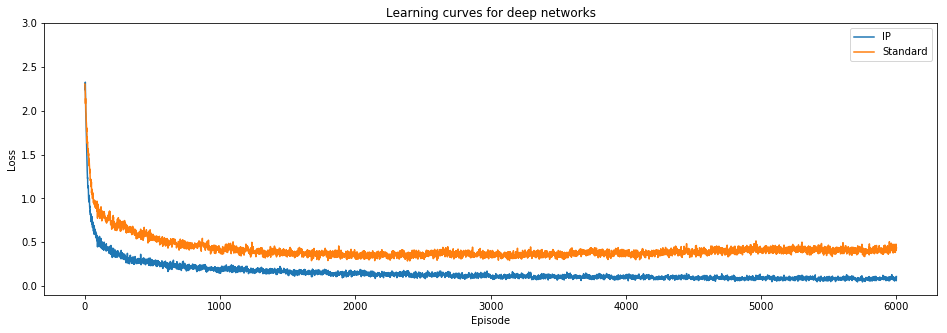

In [23]:
plt.figure(figsize=(16, 5))
plt.ylim([-0.1, 3])
plt.title("Learning curves for deep networks")
plt.plot(ip_losses[0], ip_losses[1], label="IP")
# plt.plot(bn_losses[0], bn_losses[1], label="BN")
plt.plot(standard_losses[0], standard_losses[1], label="Standard")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50

test_runs = 10

int_lr = 0.35
syn_lr = 0.016

seed = random.randint(0, 1000000)

#Train IP Model
torch.manual_seed(seed)
IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
IPnet = IPnet.to(device)

optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
print("Training IP Net")
ip_losses = train_deep_model(IPnet, optimizer1, seed)


#Train Standard Model
torch.manual_seed(seed)
net = DNet(LAYERSIZE, NN, eta=int_lr)
net = net.to(device)

optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
print("Training Standard Net")
standard_losses = train_deep_model(net, optimizer2, seed)

for i in range(test_runs-1):
    seed = random.randint(0, 1000000)
    
    #Train IP Model
    torch.manual_seed(seed)
    IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net")
    ip_losses += train_deep_model(IPnet, optimizer1, seed)


    #Train Standard Model
    torch.manual_seed(seed)
    net = DNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net")
    standard_losses += train_deep_model(net, optimizer2, seed)
    
ip_losses = ip_losses/test_runs
standard_losses = standard_losses/test_runs

Training IP Net
[1,   100] loss: 0.997
[1,   200] loss: 0.484
[1,   300] loss: 0.414
[2,   100] loss: 0.366
[2,   200] loss: 0.301
[2,   300] loss: 0.296
[3,   100] loss: 0.257
[3,   200] loss: 0.252
[3,   300] loss: 0.228
[4,   100] loss: 0.218
[4,   200] loss: 0.200
[4,   300] loss: 0.199
[5,   100] loss: 0.183
[5,   200] loss: 0.197
[5,   300] loss: 0.189
[6,   100] loss: 0.162
[6,   200] loss: 0.181
[6,   300] loss: 0.191
[7,   100] loss: 0.167
[7,   200] loss: 0.145
[7,   300] loss: 0.168
[8,   100] loss: 0.149
[8,   200] loss: 0.149
[8,   300] loss: 0.159
[9,   100] loss: 0.139
[9,   200] loss: 0.143
[9,   300] loss: 0.138
[10,   100] loss: 0.140
[10,   200] loss: 0.135
[10,   300] loss: 0.149
[11,   100] loss: 0.135
[11,   200] loss: 0.126
[11,   300] loss: 0.130
[12,   100] loss: 0.119
[12,   200] loss: 0.146
[12,   300] loss: 0.140
[13,   100] loss: 0.121
[13,   200] loss: 0.116
[13,   300] loss: 0.123
[14,   100] loss: 0.117
[14,   200] loss: 0.113
[14,   300] loss: 0.114
[15

[14,   200] loss: 2.303
[14,   300] loss: 2.303
[15,   100] loss: 2.303
[15,   200] loss: 2.303
[15,   300] loss: 2.303
[16,   100] loss: 2.303
[16,   200] loss: 2.303
[16,   300] loss: 2.303
[17,   100] loss: 2.303
[17,   200] loss: 2.303
[17,   300] loss: 2.303
[18,   100] loss: 2.303
[18,   200] loss: 2.303
[18,   300] loss: 2.303
[19,   100] loss: 2.303
[19,   200] loss: 2.303
[19,   300] loss: 2.303
[20,   100] loss: 2.303
[20,   200] loss: 2.303
[20,   300] loss: 2.303
Finished training!

Training IP Net
[1,   100] loss: 2.308
[1,   200] loss: 2.303
[1,   300] loss: 2.303
[2,   100] loss: 2.303
[2,   200] loss: 2.303
[2,   300] loss: 2.303
[3,   100] loss: 2.303
[3,   200] loss: 2.303
[3,   300] loss: 2.303
[4,   100] loss: 2.303
[4,   200] loss: 2.303
[4,   300] loss: 2.303
[5,   100] loss: 2.303
[5,   200] loss: 2.303
[5,   300] loss: 2.303
[6,   100] loss: 2.303
[6,   200] loss: 2.303
[6,   300] loss: 2.303
[7,   100] loss: 2.303
[7,   200] loss: 2.303
[7,   300] loss: 2.303
[

[7,   100] loss: 2.303
[7,   200] loss: 2.303
[7,   300] loss: 2.303
[8,   100] loss: 2.303
[8,   200] loss: 2.303
[8,   300] loss: 2.303
[9,   100] loss: 2.303
[9,   200] loss: 2.303
[9,   300] loss: 2.303
[10,   100] loss: 2.303
[10,   200] loss: 2.303
[10,   300] loss: 2.303
[11,   100] loss: 2.303
[11,   200] loss: 2.303
[11,   300] loss: 2.303
[12,   100] loss: 2.303
[12,   200] loss: 2.303
[12,   300] loss: 2.303
[13,   100] loss: 2.303
[13,   200] loss: 2.303
[13,   300] loss: 2.303
[14,   100] loss: 2.303
[14,   200] loss: 2.303
[14,   300] loss: 2.303
[15,   100] loss: 2.303
[15,   200] loss: 2.303
[15,   300] loss: 2.303
[16,   100] loss: 2.303
[16,   200] loss: 2.303
[16,   300] loss: 2.303
[17,   100] loss: 2.303
[17,   200] loss: 2.303
[17,   300] loss: 2.303
[18,   100] loss: 2.303
[18,   200] loss: 2.303
[18,   300] loss: 2.303
[19,   100] loss: 2.303
[19,   200] loss: 2.303
[19,   300] loss: 2.303
[20,   100] loss: 2.303
[20,   200] loss: 2.303
[20,   300] loss: 2.303
F

[20,   200] loss: 2.083
[20,   300] loss: 2.096
Finished training!

Training Standard Net
[1,   100] loss: 2.178
[1,   200] loss: 2.122
[1,   300] loss: 2.100
[2,   100] loss: 2.103
[2,   200] loss: 2.187
[2,   300] loss: 2.303
[3,   100] loss: 2.303
[3,   200] loss: 2.303
[3,   300] loss: 2.303
[4,   100] loss: 2.303
[4,   200] loss: 2.303
[4,   300] loss: 2.303
[5,   100] loss: 2.303
[5,   200] loss: 2.303
[5,   300] loss: 2.303
[6,   100] loss: 2.303
[6,   200] loss: 2.303
[6,   300] loss: 2.303
[7,   100] loss: 2.303
[7,   200] loss: 2.303
[7,   300] loss: 2.303
[8,   100] loss: 2.303
[8,   200] loss: 2.303
[8,   300] loss: 2.303
[9,   100] loss: 2.303
[9,   200] loss: 2.303
[9,   300] loss: 2.303
[10,   100] loss: 2.303
[10,   200] loss: 2.303
[10,   300] loss: 2.303
[11,   100] loss: 2.303
[11,   200] loss: 2.303
[11,   300] loss: 2.303
[12,   100] loss: 2.303
[12,   200] loss: 2.303
[12,   300] loss: 2.303
[13,   100] loss: 2.303
[13,   200] loss: 2.303
[13,   300] loss: 2.303
[

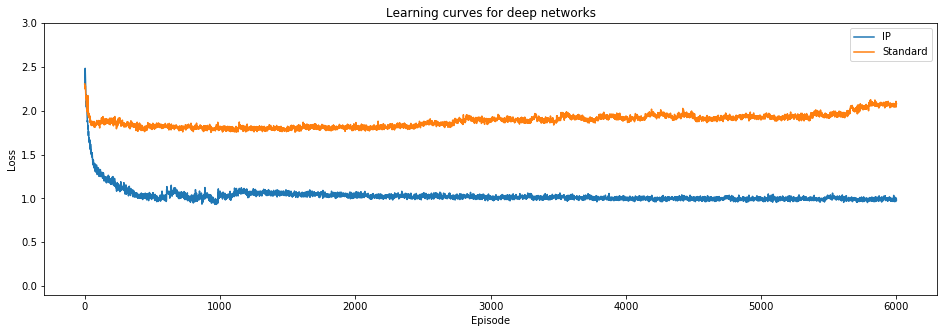

In [35]:
plt.figure(figsize=(16, 5))
plt.ylim([-0.1, 3])
plt.title("Learning curves for deep networks")
plt.plot(ip_losses[0], ip_losses[1], label="IP")
# plt.plot(bn_losses[0], bn_losses[1], label="BN")
plt.plot(standard_losses[0], standard_losses[1], label="Standard")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [6]:
class CDNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(CDNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(3*32*32, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 3*32*32)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        
        return o

In [7]:
batchSize = 200

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 150

test_runs = 10

int_lr = 0.3
syn_lr = 0.001

seed = random.randint(0, 1000000)

#Train IP Model
torch.manual_seed(seed)
IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
IPnet = IPnet.to(device)

optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
print("Training IP Net")
ip_losses = train_deep_model(IPnet, optimizer1, seed)


#Train Standard Model
torch.manual_seed(seed)
net = CDNet(LAYERSIZE, NN, eta=int_lr)
net = net.to(device)

optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
print("Training Standard Net")
standard_losses = train_deep_model(net, optimizer2, seed)

for i in range(test_runs-1):
    seed = random.randint(0, 1000000)
    
    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net")
    ip_losses += train_deep_model(IPnet, optimizer1, seed)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CDNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net")
    standard_losses += train_deep_model(net, optimizer2, seed)
    
ip_losses = ip_losses/test_runs
standard_losses = standard_losses/test_runs

Training IP Net
[1,   100] loss: 1.952
[1,   200] loss: 1.812
[2,   100] loss: 1.700
[2,   200] loss: 1.676
[3,   100] loss: 1.595
[3,   200] loss: 1.588
[4,   100] loss: 1.502
[4,   200] loss: 1.521
[5,   100] loss: 1.437
[5,   200] loss: 1.467
[6,   100] loss: 1.386
[6,   200] loss: 1.402
[7,   100] loss: 1.324
[7,   200] loss: 1.370
[8,   100] loss: 1.287
[8,   200] loss: 1.331
[9,   100] loss: 1.239
[9,   200] loss: 1.267
[10,   100] loss: 1.194
[10,   200] loss: 1.216
[11,   100] loss: 1.147
[11,   200] loss: 1.195
[12,   100] loss: 1.107
[12,   200] loss: 1.154
[13,   100] loss: 1.060
[13,   200] loss: 1.120
[14,   100] loss: 1.040
[14,   200] loss: 1.064
[15,   100] loss: 1.010
[15,   200] loss: 1.039
[16,   100] loss: 0.988
[16,   200] loss: 0.996
[17,   100] loss: 0.936
[17,   200] loss: 0.984
[18,   100] loss: 0.905
[18,   200] loss: 0.961
[19,   100] loss: 0.880
[19,   200] loss: 0.935
[20,   100] loss: 0.871
[20,   200] loss: 0.904
Finished training!

Training Standard Net


[8,   200] loss: 1.320
[9,   100] loss: 1.255
[9,   200] loss: 1.275
[10,   100] loss: 1.203
[10,   200] loss: 1.232
[11,   100] loss: 1.159
[11,   200] loss: 1.191
[12,   100] loss: 1.127
[12,   200] loss: 1.159
[13,   100] loss: 1.089
[13,   200] loss: 1.112
[14,   100] loss: 1.040
[14,   200] loss: 1.097
[15,   100] loss: 0.999
[15,   200] loss: 1.062
[16,   100] loss: 0.984
[16,   200] loss: 1.019
[17,   100] loss: 0.946
[17,   200] loss: 0.989
[18,   100] loss: 0.924
[18,   200] loss: 0.959
[19,   100] loss: 0.892
[19,   200] loss: 0.933
[20,   100] loss: 0.853
[20,   200] loss: 0.920
Finished training!

Training Standard Net
[1,   100] loss: 1.998
[1,   200] loss: 1.866
[2,   100] loss: 1.765
[2,   200] loss: 1.731
[3,   100] loss: 1.660
[3,   200] loss: 1.665
[4,   100] loss: 1.596
[4,   200] loss: 1.610
[5,   100] loss: 1.549
[5,   200] loss: 1.551
[6,   100] loss: 1.503
[6,   200] loss: 1.512
[7,   100] loss: 1.461
[7,   200] loss: 1.467
[8,   100] loss: 1.405
[8,   200] loss:

[16,   100] loss: 0.973
[16,   200] loss: 1.020
[17,   100] loss: 0.949
[17,   200] loss: 0.981
[18,   100] loss: 0.915
[18,   200] loss: 0.950
[19,   100] loss: 0.875
[19,   200] loss: 0.938
[20,   100] loss: 0.850
[20,   200] loss: 0.917
Finished training!

Training Standard Net
[1,   100] loss: 2.025
[1,   200] loss: 1.866
[2,   100] loss: 1.772
[2,   200] loss: 1.750
[3,   100] loss: 1.664
[3,   200] loss: 1.677
[4,   100] loss: 1.604
[4,   200] loss: 1.612
[5,   100] loss: 1.552
[5,   200] loss: 1.562
[6,   100] loss: 1.502
[6,   200] loss: 1.512
[7,   100] loss: 1.466
[7,   200] loss: 1.482
[8,   100] loss: 1.415
[8,   200] loss: 1.442
[9,   100] loss: 1.408
[9,   200] loss: 1.399
[10,   100] loss: 1.347
[10,   200] loss: 1.384
[11,   100] loss: 1.315
[11,   200] loss: 1.342
[12,   100] loss: 1.285
[12,   200] loss: 1.312
[13,   100] loss: 1.252
[13,   200] loss: 1.280
[14,   100] loss: 1.221
[14,   200] loss: 1.257
[15,   100] loss: 1.192
[15,   200] loss: 1.232
[16,   100] loss

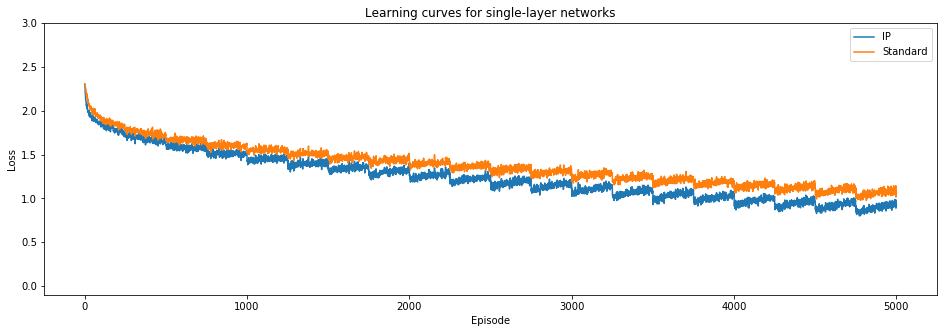

In [15]:
plt.figure(figsize=(16, 5))
plt.ylim([-0.1, 3])
plt.title("Learning curves for deep networks")
plt.plot(ip_losses[0], ip_losses[1], label="IP")
# plt.plot(bn_losses[0], bn_losses[1], label="BN")
plt.plot(standard_losses[0], standard_losses[1], label="Standard")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

Training IP Net
[1,   100] loss: 2.113
[1,   200] loss: 2.038
[2,   100] loss: 1.994
[2,   200] loss: 1.996
[3,   100] loss: 1.938
[3,   200] loss: 1.903
[4,   100] loss: 1.826
[4,   200] loss: 1.803
[5,   100] loss: 1.762
[5,   200] loss: 1.753
[6,   100] loss: 1.707
[6,   200] loss: 1.694
[7,   100] loss: 1.658
[7,   200] loss: 1.635
[8,   100] loss: 1.569
[8,   200] loss: 1.567
[9,   100] loss: 1.486
[9,   200] loss: 1.496
[10,   100] loss: 1.450
[10,   200] loss: 1.445
[11,   100] loss: 1.384
[11,   200] loss: 1.394
[12,   100] loss: 1.311
[12,   200] loss: 1.326
[13,   100] loss: 1.260
[13,   200] loss: 1.287
[14,   100] loss: 1.210
[14,   200] loss: 1.235
[15,   100] loss: 1.153
[15,   200] loss: 1.178
[16,   100] loss: 1.107
[16,   200] loss: 1.109
[17,   100] loss: 1.067
[17,   200] loss: 1.087
[18,   100] loss: 1.004
[18,   200] loss: 1.035
[19,   100] loss: 0.951
[19,   200] loss: 0.985
[20,   100] loss: 0.926
[20,   200] loss: 0.949
[21,   100] loss: 0.881
[21,   200] loss: 

[10,   100] loss: 1.400
[10,   200] loss: 1.428
[11,   100] loss: 1.352
[11,   200] loss: 1.369
[12,   100] loss: 1.296
[12,   200] loss: 1.315
[13,   100] loss: 1.234
[13,   200] loss: 1.262
[14,   100] loss: 1.205
[14,   200] loss: 1.189
[15,   100] loss: 1.142
[15,   200] loss: 1.167
[16,   100] loss: 1.084
[16,   200] loss: 1.108
[17,   100] loss: 1.024
[17,   200] loss: 1.066
[18,   100] loss: 0.982
[18,   200] loss: 1.025
[19,   100] loss: 0.933
[19,   200] loss: 0.974
[20,   100] loss: 0.902
[20,   200] loss: 0.931
[21,   100] loss: 0.844
[21,   200] loss: 0.885
[22,   100] loss: 0.804
[22,   200] loss: 0.849
[23,   100] loss: 0.799
[23,   200] loss: 0.813
[24,   100] loss: 0.735
[24,   200] loss: 0.782
[25,   100] loss: 0.717
[25,   200] loss: 0.740
[26,   100] loss: 0.681
[26,   200] loss: 0.712
[27,   100] loss: 0.651
[27,   200] loss: 0.692
[28,   100] loss: 0.616
[28,   200] loss: 0.660
[29,   100] loss: 0.596
[29,   200] loss: 0.629
[30,   100] loss: 0.582
[30,   200] loss

[19,   100] loss: 0.904
[19,   200] loss: 0.948
[20,   100] loss: 0.851
[20,   200] loss: 0.891
[21,   100] loss: 0.822
[21,   200] loss: 0.850
[22,   100] loss: 0.784
[22,   200] loss: 0.810
[23,   100] loss: 0.729
[23,   200] loss: 0.783
[24,   100] loss: 0.710
[24,   200] loss: 0.762
[25,   100] loss: 0.682
[25,   200] loss: 0.704
[26,   100] loss: 0.653
[26,   200] loss: 0.667
[27,   100] loss: 0.603
[27,   200] loss: 0.651
[28,   100] loss: 0.581
[28,   200] loss: 0.628
[29,   100] loss: 0.566
[29,   200] loss: 0.590
[30,   100] loss: 0.549
[30,   200] loss: 0.558
[31,   100] loss: 0.513
[31,   200] loss: 0.531
[32,   100] loss: 0.501
[32,   200] loss: 0.518
[33,   100] loss: 0.461
[33,   200] loss: 0.497
[34,   100] loss: 0.440
[34,   200] loss: 0.472
[35,   100] loss: 0.428
[35,   200] loss: 0.458
[36,   100] loss: 0.408
[36,   200] loss: 0.458
[37,   100] loss: 0.406
[37,   200] loss: 0.421
[38,   100] loss: 0.396
[38,   200] loss: 0.405
[39,   100] loss: 0.357
[39,   200] loss

[28,   100] loss: 0.638
[28,   200] loss: 0.671
[29,   100] loss: 0.618
[29,   200] loss: 0.651
[30,   100] loss: 0.593
[30,   200] loss: 0.609
[31,   100] loss: 0.552
[31,   200] loss: 0.592
[32,   100] loss: 0.537
[32,   200] loss: 0.571
[33,   100] loss: 0.505
[33,   200] loss: 0.551
[34,   100] loss: 0.504
[34,   200] loss: 0.512
[35,   100] loss: 0.481
[35,   200] loss: 0.515
[36,   100] loss: 0.451
[36,   200] loss: 0.503
[37,   100] loss: 0.430
[37,   200] loss: 0.452
[38,   100] loss: 0.416
[38,   200] loss: 0.447
[39,   100] loss: 0.397
[39,   200] loss: 0.440
[40,   100] loss: 0.388
[40,   200] loss: 0.424
Finished training!

Training Standard Net
[1,   100] loss: 2.157
[1,   200] loss: 2.047
[2,   100] loss: 2.011
[2,   200] loss: 1.986
[3,   100] loss: 1.981
[3,   200] loss: 1.984
[4,   100] loss: 1.978
[4,   200] loss: 1.965
[5,   100] loss: 1.963
[5,   200] loss: 1.955
[6,   100] loss: 1.957
[6,   200] loss: 1.970
[7,   100] loss: 1.944
[7,   200] loss: 1.959
[8,   100] l

[37,   100] loss: 0.398
[37,   200] loss: 0.430
[38,   100] loss: 0.390
[38,   200] loss: 0.409
[39,   100] loss: 0.375
[39,   200] loss: 0.416
[40,   100] loss: 0.368
[40,   200] loss: 0.400
Finished training!

Training Standard Net
[1,   100] loss: 2.132
[1,   200] loss: 2.037
[2,   100] loss: 1.999
[2,   200] loss: 2.034
[3,   100] loss: 1.995
[3,   200] loss: 2.003
[4,   100] loss: 1.971
[4,   200] loss: 1.960
[5,   100] loss: 1.951
[5,   200] loss: 1.967
[6,   100] loss: 1.955
[6,   200] loss: 1.938
[7,   100] loss: 1.944
[7,   200] loss: 1.950
[8,   100] loss: 1.942
[8,   200] loss: 1.933
[9,   100] loss: 1.922
[9,   200] loss: 1.917
[10,   100] loss: 1.919
[10,   200] loss: 1.932
[11,   100] loss: 1.915
[11,   200] loss: 1.956
[12,   100] loss: 1.903
[12,   200] loss: 1.922
[13,   100] loss: 1.899
[13,   200] loss: 1.913
[14,   100] loss: 1.913
[14,   200] loss: 1.903
[15,   100] loss: 1.900
[15,   200] loss: 1.912
[16,   100] loss: 1.900
[16,   200] loss: 1.906
[17,   100] loss

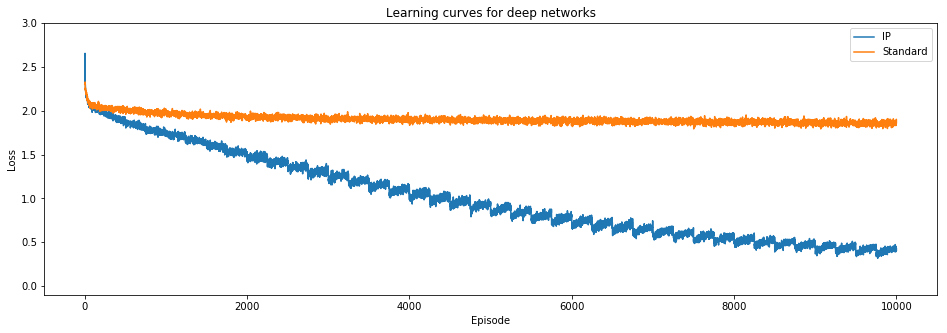

Training IP Net
[1,   100] loss: 2.192
[1,   200] loss: 2.045
[2,   100] loss: 1.929
[2,   200] loss: 1.915
[3,   100] loss: 1.841
[3,   200] loss: 1.807
[4,   100] loss: 1.758
[4,   200] loss: 1.737
[5,   100] loss: 1.690
[5,   200] loss: 1.689
[6,   100] loss: 1.620
[6,   200] loss: 1.619
[7,   100] loss: 1.541
[7,   200] loss: 1.546
[8,   100] loss: 1.476
[8,   200] loss: 1.487
[9,   100] loss: 1.403
[9,   200] loss: 1.432
[10,   100] loss: 1.355
[10,   200] loss: 1.385
[11,   100] loss: 1.320
[11,   200] loss: 1.327
[12,   100] loss: 1.251
[12,   200] loss: 1.289
[13,   100] loss: 1.211
[13,   200] loss: 1.229
[14,   100] loss: 1.159
[14,   200] loss: 1.190
[15,   100] loss: 1.122
[15,   200] loss: 1.139
[16,   100] loss: 1.090
[16,   200] loss: 1.117
[17,   100] loss: 1.046
[17,   200] loss: 1.052
[18,   100] loss: 0.995
[18,   200] loss: 1.031
[19,   100] loss: 0.962
[19,   200] loss: 0.974
[20,   100] loss: 0.911
[20,   200] loss: 0.954
[21,   100] loss: 0.882
[21,   200] loss: 

[10,   100] loss: 1.386
[10,   200] loss: 1.396
[11,   100] loss: 1.337
[11,   200] loss: 1.352
[12,   100] loss: 1.276
[12,   200] loss: 1.302
[13,   100] loss: 1.222
[13,   200] loss: 1.241
[14,   100] loss: 1.171
[14,   200] loss: 1.203
[15,   100] loss: 1.128
[15,   200] loss: 1.155
[16,   100] loss: 1.088
[16,   200] loss: 1.115
[17,   100] loss: 1.039
[17,   200] loss: 1.061
[18,   100] loss: 1.001
[18,   200] loss: 1.036
[19,   100] loss: 0.958
[19,   200] loss: 1.004
[20,   100] loss: 0.910
[20,   200] loss: 0.947
[21,   100] loss: 0.873
[21,   200] loss: 0.929
[22,   100] loss: 0.845
[22,   200] loss: 0.870
[23,   100] loss: 0.803
[23,   200] loss: 0.855
[24,   100] loss: 0.776
[24,   200] loss: 0.812
[25,   100] loss: 0.773
[25,   200] loss: 0.796
[26,   100] loss: 0.726
[26,   200] loss: 0.748
[27,   100] loss: 0.718
[27,   200] loss: 0.733
[28,   100] loss: 0.674
[28,   200] loss: 0.708
[29,   100] loss: 0.623
[29,   200] loss: 0.689
[30,   100] loss: 0.626
[30,   200] loss

[19,   100] loss: 0.912
[19,   200] loss: 0.964
[20,   100] loss: 0.886
[20,   200] loss: 0.907
[21,   100] loss: 0.856
[21,   200] loss: 0.892
[22,   100] loss: 0.835
[22,   200] loss: 0.859
[23,   100] loss: 0.783
[23,   200] loss: 0.844
[24,   100] loss: 0.765
[24,   200] loss: 0.778
[25,   100] loss: 0.723
[25,   200] loss: 0.755
[26,   100] loss: 0.703
[26,   200] loss: 0.741
[27,   100] loss: 0.668
[27,   200] loss: 0.713
[28,   100] loss: 0.665
[28,   200] loss: 0.671
[29,   100] loss: 0.636
[29,   200] loss: 0.676
[30,   100] loss: 0.620
[30,   200] loss: 0.640
[31,   100] loss: 0.600
[31,   200] loss: 0.617
[32,   100] loss: 0.549
[32,   200] loss: 0.579
[33,   100] loss: 0.535
[33,   200] loss: 0.567
[34,   100] loss: 0.532
[34,   200] loss: 0.539
[35,   100] loss: 0.500
[35,   200] loss: 0.535
[36,   100] loss: 0.504
[36,   200] loss: 0.523
[37,   100] loss: 0.490
[37,   200] loss: 0.505
[38,   100] loss: 0.458
[38,   200] loss: 0.505
[39,   100] loss: 0.457
[39,   200] loss

[28,   100] loss: 0.706
[28,   200] loss: 0.736
[29,   100] loss: 0.667
[29,   200] loss: 0.719
[30,   100] loss: 0.661
[30,   200] loss: 0.681
[31,   100] loss: 0.638
[31,   200] loss: 0.663
[32,   100] loss: 0.607
[32,   200] loss: 0.629
[33,   100] loss: 0.581
[33,   200] loss: 0.617
[34,   100] loss: 0.571
[34,   200] loss: 0.592
[35,   100] loss: 0.552
[35,   200] loss: 0.575
[36,   100] loss: 0.525
[36,   200] loss: 0.542
[37,   100] loss: 0.511
[37,   200] loss: 0.535
[38,   100] loss: 0.484
[38,   200] loss: 0.524
[39,   100] loss: 0.474
[39,   200] loss: 0.506
[40,   100] loss: 0.491
[40,   200] loss: 0.508
Finished training!

Training Standard Net
[1,   100] loss: 2.344
[1,   200] loss: 2.328
[2,   100] loss: 2.317
[2,   200] loss: 2.304
[3,   100] loss: 2.302
[3,   200] loss: 2.303
[4,   100] loss: 2.307
[4,   200] loss: 2.303
[5,   100] loss: 2.305
[5,   200] loss: 2.302
[6,   100] loss: 2.303
[6,   200] loss: 2.303
[7,   100] loss: 2.303
[7,   200] loss: 2.303
[8,   100] l

[37,   100] loss: 0.496
[37,   200] loss: 0.539
[38,   100] loss: 0.480
[38,   200] loss: 0.508
[39,   100] loss: 0.462
[39,   200] loss: 0.500
[40,   100] loss: 0.444
[40,   200] loss: 0.489
Finished training!

Training Standard Net
[1,   100] loss: 2.308
[1,   200] loss: 2.294
[2,   100] loss: 2.253
[2,   200] loss: 2.247
[3,   100] loss: 2.235
[3,   200] loss: 2.198
[4,   100] loss: 2.193
[4,   200] loss: 2.197
[5,   100] loss: 2.168
[5,   200] loss: 2.164
[6,   100] loss: 2.165
[6,   200] loss: 2.166
[7,   100] loss: 2.144
[7,   200] loss: 2.146
[8,   100] loss: 2.142
[8,   200] loss: 2.153
[9,   100] loss: 2.162
[9,   200] loss: 2.128
[10,   100] loss: 2.133
[10,   200] loss: 2.145
[11,   100] loss: 2.123
[11,   200] loss: 2.138
[12,   100] loss: 2.131
[12,   200] loss: 2.130
[13,   100] loss: 2.141
[13,   200] loss: 2.141
[14,   100] loss: 2.135
[14,   200] loss: 2.147
[15,   100] loss: 2.135
[15,   200] loss: 2.131
[16,   100] loss: 2.145
[16,   200] loss: 2.124
[17,   100] loss

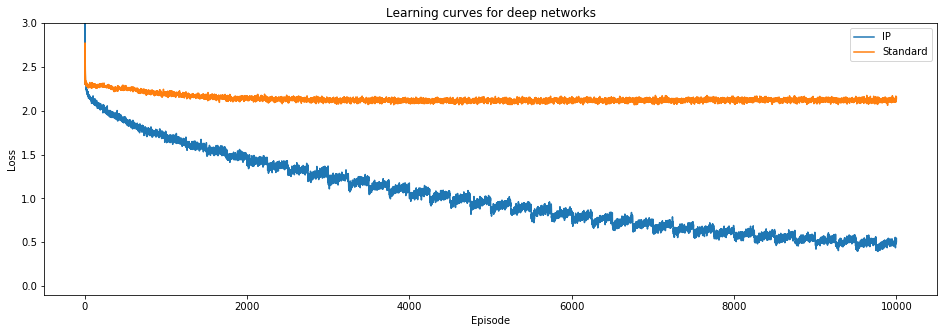

Training IP Net
[1,   100] loss: 2.318
[1,   200] loss: 2.241
[2,   100] loss: 2.186
[2,   200] loss: 2.147
[3,   100] loss: 2.103
[3,   200] loss: 2.104
[4,   100] loss: 2.075
[4,   200] loss: 2.069
[5,   100] loss: 2.045
[5,   200] loss: 2.039
[6,   100] loss: 2.013
[6,   200] loss: 2.008
[7,   100] loss: 1.992
[7,   200] loss: 1.996
[8,   100] loss: 2.000
[8,   200] loss: 2.002
[9,   100] loss: 1.984
[9,   200] loss: 1.968
[10,   100] loss: 1.971
[10,   200] loss: 1.958
[11,   100] loss: 1.959
[11,   200] loss: 1.933
[12,   100] loss: 1.927
[12,   200] loss: 1.933
[13,   100] loss: 1.930
[13,   200] loss: 1.924
[14,   100] loss: 1.920
[14,   200] loss: 1.910
[15,   100] loss: 1.915
[15,   200] loss: 1.945
[16,   100] loss: 1.932
[16,   200] loss: 1.940
[17,   100] loss: 1.933
[17,   200] loss: 1.940
[18,   100] loss: 1.930
[18,   200] loss: 1.929
[19,   100] loss: 1.931
[19,   200] loss: 1.913
[20,   100] loss: 1.907
[20,   200] loss: 1.916
[21,   100] loss: 1.904
[21,   200] loss: 

[10,   100] loss: 1.903
[10,   200] loss: 1.910
[11,   100] loss: 1.884
[11,   200] loss: 1.893
[12,   100] loss: 1.892
[12,   200] loss: 1.883
[13,   100] loss: 1.855
[13,   200] loss: 1.865
[14,   100] loss: 1.854
[14,   200] loss: 1.859
[15,   100] loss: 1.832
[15,   200] loss: 1.851
[16,   100] loss: 1.860
[16,   200] loss: 1.856
[17,   100] loss: 1.821
[17,   200] loss: 1.827
[18,   100] loss: 1.803
[18,   200] loss: 1.798
[19,   100] loss: 1.777
[19,   200] loss: 1.787
[20,   100] loss: 1.797
[20,   200] loss: 1.789
[21,   100] loss: 1.780
[21,   200] loss: 1.764
[22,   100] loss: 1.738
[22,   200] loss: 1.760
[23,   100] loss: 1.765
[23,   200] loss: 1.779
[24,   100] loss: 1.757
[24,   200] loss: 1.782
[25,   100] loss: 1.771
[25,   200] loss: 1.759
[26,   100] loss: 1.741
[26,   200] loss: 1.777
[27,   100] loss: 1.752
[27,   200] loss: 1.762
[28,   100] loss: 1.725
[28,   200] loss: 1.745
[29,   100] loss: 1.724
[29,   200] loss: 1.755
[30,   100] loss: 1.733
[30,   200] loss

[19,   100] loss: 2.303
[19,   200] loss: 2.303
[20,   100] loss: 2.303
[20,   200] loss: 2.303
[21,   100] loss: 2.303
[21,   200] loss: 2.303
[22,   100] loss: 2.303
[22,   200] loss: 2.303
[23,   100] loss: 2.303
[23,   200] loss: 2.303
[24,   100] loss: 2.303
[24,   200] loss: 2.303
[25,   100] loss: 2.303
[25,   200] loss: 2.303
[26,   100] loss: 2.303
[26,   200] loss: 2.303
[27,   100] loss: 2.303
[27,   200] loss: 2.303
[28,   100] loss: 2.303
[28,   200] loss: 2.303
[29,   100] loss: 2.303
[29,   200] loss: 2.303
[30,   100] loss: 2.303
[30,   200] loss: 2.303
[31,   100] loss: 2.303
[31,   200] loss: 2.303
[32,   100] loss: 2.303
[32,   200] loss: 2.303
[33,   100] loss: 2.303
[33,   200] loss: 2.303
[34,   100] loss: 2.303
[34,   200] loss: 2.303
[35,   100] loss: 2.303
[35,   200] loss: 2.303
[36,   100] loss: 2.303
[36,   200] loss: 2.303
[37,   100] loss: 2.303
[37,   200] loss: 2.303
[38,   100] loss: 2.303
[38,   200] loss: 2.303
[39,   100] loss: 2.303
[39,   200] loss

[28,   100] loss: 2.245
[28,   200] loss: 2.255
[29,   100] loss: 2.270
[29,   200] loss: 2.265
[30,   100] loss: 2.266
[30,   200] loss: 2.259
[31,   100] loss: 2.263
[31,   200] loss: 2.290
[32,   100] loss: 2.303
[32,   200] loss: 2.303
[33,   100] loss: 2.303
[33,   200] loss: 2.303
[34,   100] loss: 2.303
[34,   200] loss: 2.303
[35,   100] loss: 2.303
[35,   200] loss: 2.303
[36,   100] loss: 2.303
[36,   200] loss: 2.303
[37,   100] loss: 2.303
[37,   200] loss: 2.303
[38,   100] loss: 2.303
[38,   200] loss: 2.303
[39,   100] loss: 2.303
[39,   200] loss: 2.303
[40,   100] loss: 2.303
[40,   200] loss: 2.303
Finished training!

Training Standard Net
[1,   100] loss: 2.362
[1,   200] loss: 2.328
[2,   100] loss: 2.333
[2,   200] loss: 2.278
[3,   100] loss: 2.278
[3,   200] loss: 2.285
[4,   100] loss: 2.274
[4,   200] loss: 2.286
[5,   100] loss: 2.298
[5,   200] loss: 2.303
[6,   100] loss: 2.292
[6,   200] loss: 2.290
[7,   100] loss: 2.297
[7,   200] loss: 2.301
[8,   100] l

[37,   100] loss: 2.303
[37,   200] loss: 2.303
[38,   100] loss: 2.303
[38,   200] loss: 2.303
[39,   100] loss: 2.303
[39,   200] loss: 2.303
[40,   100] loss: 2.303
[40,   200] loss: 2.303
Finished training!

Training Standard Net
[1,   100] loss: 2.344
[1,   200] loss: 2.312
[2,   100] loss: 2.313
[2,   200] loss: 2.301
[3,   100] loss: 2.302
[3,   200] loss: 2.303
[4,   100] loss: 2.303
[4,   200] loss: 2.303
[5,   100] loss: 2.303
[5,   200] loss: 2.303
[6,   100] loss: 2.303
[6,   200] loss: 2.303
[7,   100] loss: 2.303
[7,   200] loss: 2.303
[8,   100] loss: 2.303
[8,   200] loss: 2.303
[9,   100] loss: 2.303
[9,   200] loss: 2.303
[10,   100] loss: 2.303
[10,   200] loss: 2.303
[11,   100] loss: 2.303
[11,   200] loss: 2.303
[12,   100] loss: 2.303
[12,   200] loss: 2.303
[13,   100] loss: 2.303
[13,   200] loss: 2.303
[14,   100] loss: 2.303
[14,   200] loss: 2.303
[15,   100] loss: 2.303
[15,   200] loss: 2.303
[16,   100] loss: 2.303
[16,   200] loss: 2.303
[17,   100] loss

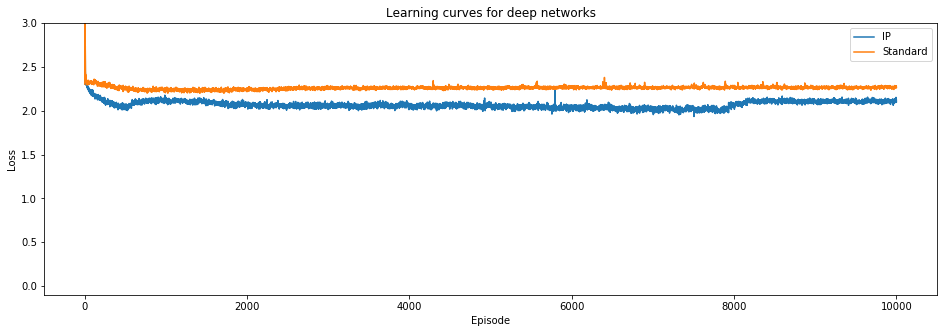

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 300

test_runs = 10
epochs = 40

int_lr = 0.3
syn_lr = 0.003

seed = random.randint(0, 1000000)

#Train IP Model
torch.manual_seed(seed)
IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
IPnet = IPnet.to(device)

optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
print("Training IP Net")
ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


#Train Standard Model
torch.manual_seed(seed)
net = CDNet(LAYERSIZE, NN, eta=int_lr)
net = net.to(device)

optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
print("Training Standard Net")
standard_losses = train_deep_model(net, optimizer2, seed, epochs)

for i in range(test_runs-1):
    seed = random.randint(0, 1000000)
    
    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net")
    ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CDNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net")
    standard_losses += train_deep_model(net, optimizer2, seed, epochs)
    
ip_losses = ip_losses/test_runs
standard_losses = standard_losses/test_runs

plt.figure(figsize=(16, 5))
plt.ylim([-0.1, 3])
plt.title("Learning curves for deep networks")
plt.plot(ip_losses[0], ip_losses[1], label="IP")
# plt.plot(bn_losses[0], bn_losses[1], label="BN")
plt.plot(standard_losses[0], standard_losses[1], label="Standard")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

int_lr = 0.3
syn_lr = 0.006

seed = random.randint(0, 1000000)

#Train IP Model
torch.manual_seed(seed)
IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
IPnet = IPnet.to(device)

optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
print("Training IP Net")
ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


#Train Standard Model
torch.manual_seed(seed)
net = CDNet(LAYERSIZE, NN, eta=int_lr)
net = net.to(device)

optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
print("Training Standard Net")
standard_losses = train_deep_model(net, optimizer2, seed, epochs)

for i in range(test_runs-1):
    seed = random.randint(0, 1000000)
    
    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net")
    ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CDNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net")
    standard_losses += train_deep_model(net, optimizer2, seed, epochs)
    
ip_losses = ip_losses/test_runs
standard_losses = standard_losses/test_runs

plt.figure(figsize=(16, 5))
plt.ylim([-0.1, 3])
plt.title("Learning curves for deep networks")
plt.plot(ip_losses[0], ip_losses[1], label="IP")
# plt.plot(bn_losses[0], bn_losses[1], label="BN")
plt.plot(standard_losses[0], standard_losses[1], label="Standard")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

int_lr = 0.3
syn_lr = 0.01

seed = random.randint(0, 1000000)

#Train IP Model
torch.manual_seed(seed)
IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
IPnet = IPnet.to(device)

optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
print("Training IP Net")
ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


#Train Standard Model
torch.manual_seed(seed)
net = CDNet(LAYERSIZE, NN, eta=int_lr)
net = net.to(device)

optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
print("Training Standard Net")
standard_losses = train_deep_model(net, optimizer2, seed, epochs)

for i in range(test_runs-1):
    seed = random.randint(0, 1000000)
    
    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net")
    ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CDNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net")
    standard_losses += train_deep_model(net, optimizer2, seed, epochs)
    
ip_losses = ip_losses/test_runs
standard_losses = standard_losses/test_runs

plt.figure(figsize=(16, 5))
plt.ylim([-0.1, 3])
plt.title("Learning curves for deep networks")
plt.plot(ip_losses[0], ip_losses[1], label="IP")
# plt.plot(bn_losses[0], bn_losses[1], label="BN")
plt.plot(standard_losses[0], standard_losses[1], label="Standard")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()